In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [4]:
cons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in cons: cons[chrom] = {}
        cons[chrom][int(pos)] = float(score)

In [5]:
introns = {}
with open('../preprocessing/introns_to_taggart.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp, _, info = line.split('\t')[:10]
        bp, start, end = int(bp), int(start), int(end)
        
        if strand == '+' and bp != -1: bp -= 1
           
        if info.split(',')[0] in ['circle', 'template_switching']:bp = -1
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        assert bp not in introns[key], bp
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]
            
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp, _, info = line.split('\t')[:10]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        #assert bp not in introns[key], bp # Here
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [6]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

48194
158098


In [7]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

X, y, chroms = [], [], []
for intron, bps in known.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    c = np.array([cons[chrom][pos] if pos in cons[chrom] else 0
                  for pos in range(begin, stop)]).reshape(-1, 1)
    if strand == '-': c = c[::-1]
    
    X += [np.hstack([onehot(seq), c]).reshape(1, 70, 5)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]

X, y = np.vstack(X), np.vstack(y)
print X.shape, y.shape, len(chroms)

(48194, 70, 5) (48194, 70) 48194


In [8]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

5461 9542 33191
(33191, 70, 5) (9542, 70, 5) (5461, 70, 5)
(33191, 70) (9542, 70) (5461, 70)


In [9]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

def plot_examples(preds, true, k = 10):
    for p, t in zip(preds[:k], true[:k]):
        plt.plot(t)
        plt.plot(p)
        plt.show()
        
def shift(preds, y):
    for offset in range(-10, 10):
        total, match = 0, 0
        for p, t in zip(preds, y):
            if np.argmax(p)+offset in np.nonzero(t)[0]:
                match += 1
            total += 1
        print offset, match, total

def roc(X, y, model):
    truth = y[:, 15:45].flatten()
    
    scores = model.predict(X)[:, 15:45].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    scores = pwm_pred(X, pwm)[:, 15:45].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc))
    
    scores = dist_pred(X, dists)[:, 15:45].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.show()

# Conservation Meta

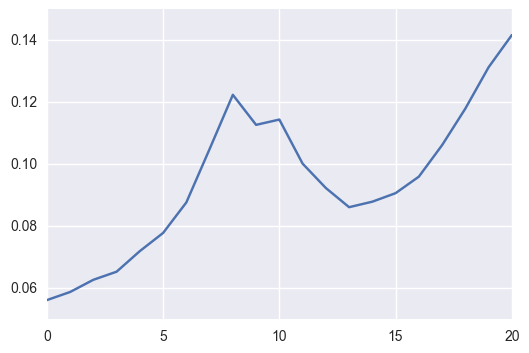

In [10]:
K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
plt.plot(counts / total)
plt.show()

# Dist Model

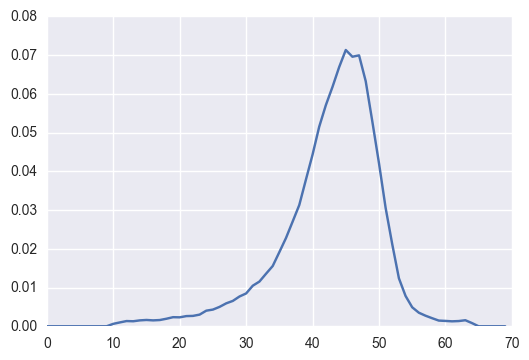

In [11]:
counts = np.zeros((L,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        counts[bp] += 1
        total += 1
dists = counts / total
plt.plot(dists)
plt.show()

In [12]:
def dist_pred(X, dists):
    return np.vstack([dists.T] * X.shape[0])

print matching(dist_pred(X_test, dists), y_test)
print matching(dist_pred(X_train, dists), y_train)

(613, 5461)
(4072, 33191)


# PWM model

In [13]:
K = 3

counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print counts
pwm = counts / total
print pwm

[[  8612.  21754.   9145.  17603.]
 [  7219.  10129.   7240.  32526.]
 [ 11314.  18449.  13608.  13743.]
 [ 39074.   8466.   3423.   6151.]
 [ 10243.  20680.   9943.  16248.]
 [ 12440.  16731.   8333.  19610.]
 [ 10938.  16033.  12007.  18136.]]
[[ 0.15078615  0.38088735  0.16011836  0.30820815]
 [ 0.12639633  0.17734706  0.12676402  0.56949259]
 [ 0.19809504  0.32302063  0.23826032  0.24062402]
 [ 0.68414049  0.14822986  0.05993277  0.10769689]
 [ 0.17934307  0.36208285  0.17409042  0.28448366]
 [ 0.21780999  0.29294043  0.14590118  0.34334839]
 [ 0.19151171  0.28071926  0.21022867  0.31754036]]


In [14]:
def pwm_pred(X, pwm):
    scores = []
    for seq in X:
        s = [0] * K
        for i in range(seq.shape[0] - K*2):
            s += [np.sum(seq[i:i+2*K+1, :4] * pwm)]
        s += [0] * K
        scores += [np.array(s)]
    return np.vstack(scores)

print matching(pwm_pred(X_test, pwm), y_test)
print matching(pwm_pred(X_train, pwm), y_train)

(1665, 5461)
(10640, 33191)


# Model trainer

In [15]:
class ModelTrainer:
    def __init__(self, model):
        self.model = model
        self.train_auc = []
        self.train_match = []
        self.valid_auc = []
        self.valid_match = []
        
    def train(self, X_train, X_valid,
              y_train, y_valid, PATIENCE = 10, EPOCHS = 1000):
        print model.summary()
        for i in range(EPOCHS):
            model.fit(X_train, y_train, epochs = 1, verbose = 0)
            self._evaluate(X_train, X_valid, y_train, y_valid)
            if (i > PATIENCE
                and max(self.valid_match[-PATIENCE:])
                < max(self.valid_match)):
                break
            print i, self.valid_match[-1], self.train_match[-1]
        self._plot_scores()
        print max(self.valid_match), max(self.valid_auc)
    
    def predict(X):
        return self.model.predict(X)
                
    def _evaluate(self, X_train, X_valid, y_train, y_valid):
        valid_preds = self.model.predict_proba(X_valid, verbose=0)
        train_preds = self.model.predict_proba(X_train, verbose=0)
        self.valid_match += [matching(valid_preds, y_valid)[0]
                             / float(y_valid.shape[0])]
        self.train_match += [matching(train_preds, y_train)[0]
                             / float(y_train.shape[0])]
        self.valid_auc += [metrics.roc_auc_score(y_valid.flatten(),
                                                 valid_preds.flatten())]
        self.train_auc += [metrics.roc_auc_score(y_train.flatten(),
                                                 train_preds.flatten())]
    
    def _plot_scores(self):
        plt.plot(self.valid_match)
        plt.plot(self.train_match)
        plt.ylabel('Match')
        plt.xlabel('epoch')
        plt.show()
        
        plt.plot(self.valid_auc)
        plt.plot(self.train_auc)
        plt.ylabel('auROC')
        plt.xlabel('epoch')
        plt.show()

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, LSTM
from keras.layers.convolutional import Conv2D
from keras import backend as k
from keras import regularizers
from keras import optimizers
from keras.layers.wrappers import Bidirectional, TimeDistributed

Using TensorFlow backend.


# Conv -> LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 1)             65        
Total params: 34,369.0
Trainable params: 34,369
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.506811989101 0.553915217981
1 0.535003143995 0.589677924739
2 0.586040662335 0.626796420716
3 0.5930622511 0.637974149619
4 0.604380632991 0.641017143201
5 0.605428631314 0.64650055738
6 0.605323831482 0.649965352053
7 0.615489415217 0.656804555452
8 0.617061412702 0.656925070049
9 0.614546216726 0.655599409478
10 0.622615803815 0.663794402097
11 0.62376860197 0.663402729656
12 0.636658

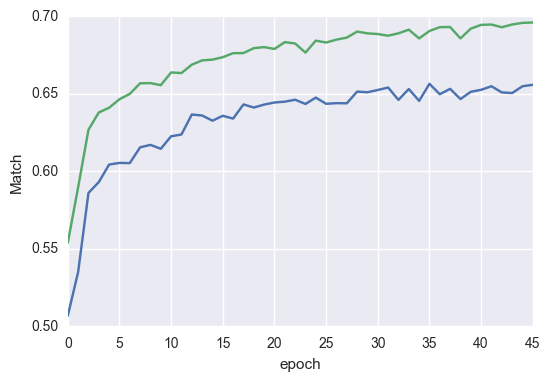

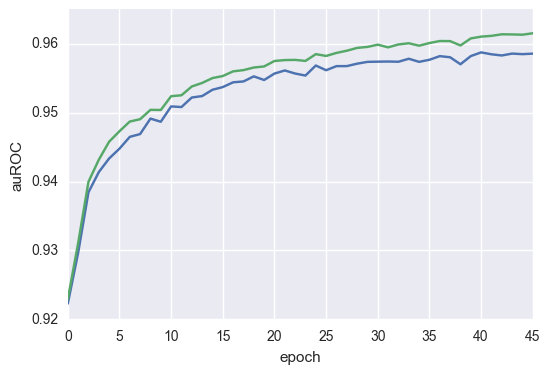

0.656466149654 0.958750854932


In [17]:
k.set_learning_phase(1)
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train[:, :, :4], X_valid[:, :, :4],
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [18]:
model.save('../models/taggart_mercer_2layer.h5')

In [26]:
def appendX(X):
    aug = np.zeros((X.shape[0], L, 1))
    for i in xrange(X.shape[0]):
        aug[i, L-1, 0] = 1
    return np.concatenate([X, aug], axis = 2)

print appendX(X_test[:, :, :4])[1]

(5461, 70, 4) (5461, 70, 1)
[[ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0. 